### TEAM ZM5

# EDSA MOVIE RECOMMENDATION CHALLENGE 

### Installing packages
Please download all relevant packages in. There is no terminal so you will need to pip install everything.

In [ ]:
#!wget 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/27685/2229266/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626387714&Signature=KygcspWYq74MDW0sfdmsG%2BKzbIVu7bAXbXSgGzeRSkW1y50gc6YBYMtbWZMOlxFxGTB4M8pHrDatrNrM7K1O7uBHHp6x1h3QEEHSnSa1X4tTYBy%2BiExhUNlV5Ez1E9Df5zYELJM1iOOtpnqWBcsndQN3mGXbpPgN4a9DBmihapuzgRXhixTX8Y3qyY9KJkoi99azSOVvQEj4S57R2KpqKOozaJUNNLSuV9z6KOoE0qzUq3%2FA5vvKE7uN7sG%2B5mmkmqAShUwzuurKBMGlty0%2FCCs8Yalhbfbto2PI4Yr%2BZJgpjxueDILjj1n1zcfeAQ083InWmYWZdd3Jbgyp4fIy0w%3D%3D&response-content-disposition=attachment%3B+filename%3Dedsa-movie-recommendation-challenge.zip'

In [ ]:
#!unzip 'archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1626387714&Signature=KygcspWYq74MDW0sfdmsG+KzbIVu7bAXbXSgGzeRSkW1y50gc6YBYMtbWZMOlxFxGTB4M8pHrDatrNrM7K1O7uBHHp6x1h3QEEHSnSa1X4tTYBy+iExhUNlV5Ez1E9Df5zYEL'

In [ ]:
#!pip install LibRecommender
#!pip install surprise
#!pip install comet_ml
#!pip install seaborn

### Imports

In [1]:
import comet_ml

In [2]:
# First import comet_ml at the top of your file
from comet_ml import Experiment

In [3]:
# Create an experiment with your api key for version control
experiment = Experiment(
    api_key="amGQj1TC3Wyk9LYf7bD9xNV6G",
    project_name="movie-reccomender-edsa",
    workspace="daniel-bru",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/daniel-bru/movie-reccomender-edsa/9abeba71f2c648d6b786ccb76f4b0f0e



In [1]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

from libreco.data import random_split, DatasetPure, DataInfo
from libreco.data import split_by_ratio_chrono, DatasetFeat
from libreco.algorithms import SVD as libSVD
from libreco.algorithms import SVDpp, BPR
from libreco.algorithms import FM, WideDeep, DeepFM, AutoInt, DIN
from libreco.evaluation import evaluate
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["KMP_WARNINGS"] = "FALSE"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time
from time import sleep
import gc

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

Instructions for updating:
non-resource variables are not supported in the long term


### Reading in data

In [2]:
root_path = ''
df_sample_submission = pd.read_csv(root_path + 'sample_submission.csv')
df_movies = pd.read_csv(root_path + 'movies.csv')
df_imdb = pd.read_csv(root_path + 'imdb_data.csv')
df_genome_scores = pd.read_csv(root_path + 'genome_scores.csv')
df_genome_tags = pd.read_csv(root_path +'genome_tags.csv')
train = pd.read_csv(root_path + 'train.csv')
df_test = pd.read_csv(root_path + 'test.csv')
df_tags = pd.read_csv(root_path + 'tags.csv')
df_links = pd.read_csv(root_path + 'links.csv')

In [6]:
pd.set_option("display.max.column", None)
print(df_sample_submission.info())
df_sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
Id        object
rating    float64
dtypes: float64(1), object(1)
memory usage: 76.3+ MB
None


,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


In [7]:
print(df_movies.info())
df_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
movieId    62423 non-null int64
title      62423 non-null object
genres     62423 non-null object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
print(df_imdb.info())
df_imdb.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
movieId          27278 non-null int64
title_cast       17210 non-null object
director         17404 non-null object
runtime          15189 non-null float64
budget           7906 non-null object
plot_keywords    16200 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB
None


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [9]:
print(df_genome_scores.info())
df_genome_scores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
movieId      int64
tagId        int64
relevance    float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [10]:
print(df_genome_tags.info())
df_genome_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
tagId    1128 non-null int64
tag      1128 non-null object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
None


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [11]:
print(df_tags.info())
df_tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
userId       1093360 non-null int64
movieId      1093360 non-null int64
tag          1093344 non-null object
timestamp    1093360 non-null int64
dtypes: int64(3), object(1)
memory usage: 33.4+ MB
None


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [12]:
print(df_links.info())
df_links.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
movieId    62423 non-null int64
imdbId     62423 non-null int64
tmdbId     62316 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [14]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
userId     int64
movieId    int64
dtypes: int64(2)
memory usage: 76.3 MB
None


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


# Exploratory Data Analysis

**Most common Genres**

In [15]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


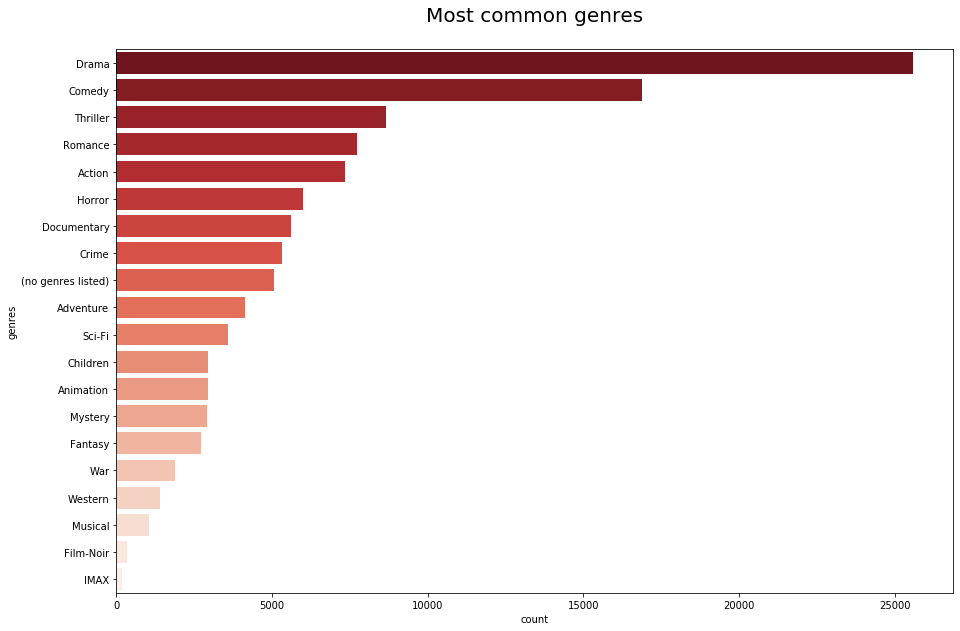

In [16]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

**Most common actors**

In [17]:
# Create dataframe containing only the movieId and cast members
cast = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_cast seperated by "|" and create a list containing the cast members in each movie
cast.title_cast = cast.title_cast.astype(str).apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie - cast member combination is in a seperate row
cast = pd.DataFrame([(tup.movieId, d) for tup in cast.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

mostc_cast = cast['title_cast'].value_counts(ascending=False).index.tolist()[:50]

print('Total Cast Members:', len(list(cast['title_cast'].unique())))
print('Most Common Cast Members:\n', mostc_cast)
display(cast.head())

Total Cast Members: 121036
Most Common Cast Members:
 ['nan', 'Samuel L. Jackson', 'Steve Buscemi', 'Keith David', 'Willem Dafoe', 'Robert De Niro', 'Gérard Depardieu', 'Brian Cox', 'Christopher Walken', 'Danny Glover', 'Morgan Freeman', 'Bruce Willis', 'Peter Stormare', 'Nicolas Cage', 'Alec Baldwin', 'Julianne Moore', 'Richard Jenkins', 'Stanley Tucci', 'Susan Sarandon', 'John Goodman', 'Woody Harrelson', 'Tom Wilkinson', 'Stellan Skarsgård', 'Christopher McDonald', 'Antonio Banderas', 'Val Kilmer', 'Jeff Bennett', 'Johnny Depp', 'Ed Harris', 'Harvey Keitel', 'John Leguizamo', 'Ray Liotta', 'Forest Whitaker', 'Donald Sutherland', 'John Cusack', 'Luis Guzmán', 'Stephen Tobolowsky', 'Paul Giamatti', 'Ewan McGregor', 'Richard Riehle', 'George W. Bush', 'David Strathairn', 'Danny Trejo', 'Jim Broadbent', 'John Malkovich', 'Ving Rhames', 'Kathy Bates', 'Patricia Clarkson', 'Robert Downey Jr.', 'Jim Cummings']


,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn


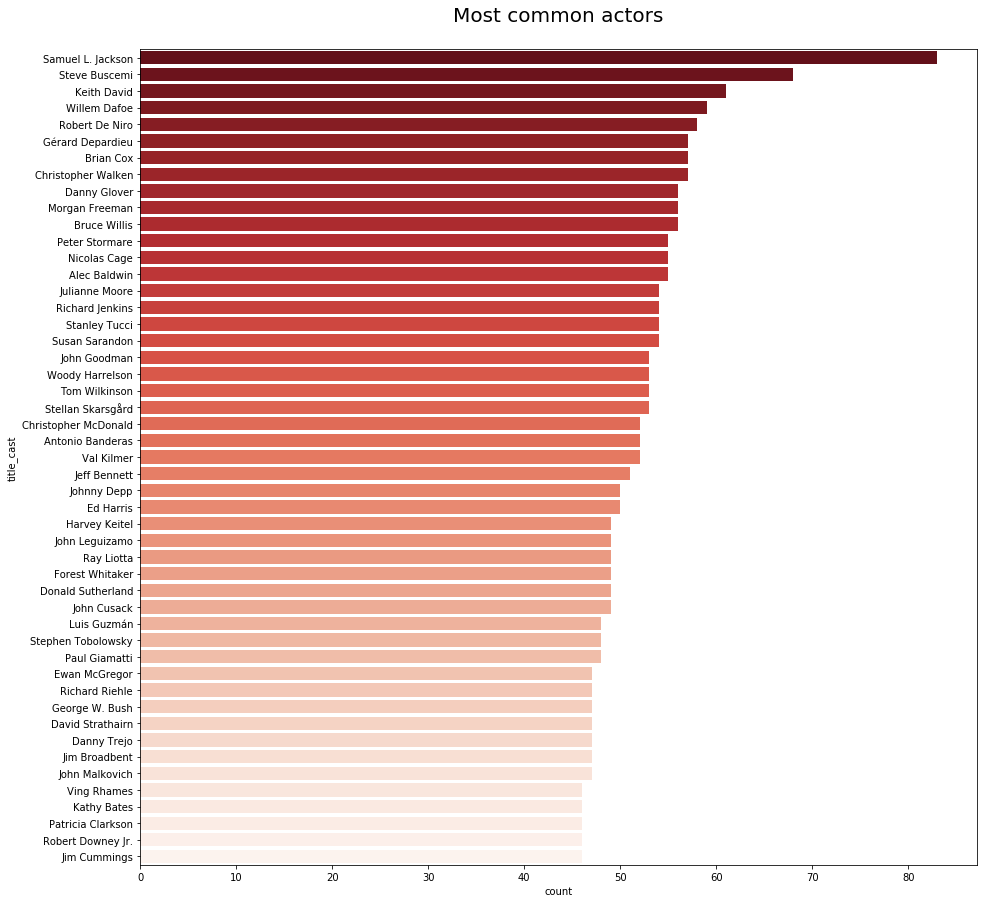

In [18]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 15))
plt.title('Most common actors\n', fontsize=20)
sns.countplot(y="title_cast", data=cast,
              order=mostc_cast[1:50],
              palette='Reds_r')
plt.show()

## Data Prepartion

In [125]:
df_train = train.copy()

rating_count = df_train.groupby('movieId')['rating'].count().reset_index()
rating_count.rename(columns = {'rating': 'movie_rating_count'}, inplace=True)
df_train = df_train.merge(rating_count, on='movieId')

user_count = df_train.groupby('userId')['rating'].count().reset_index()
user_count.rename(columns={'rating': 'user_rating_count'}, inplace=True)
df_train=df_train.merge(user_count, on='userId')

mrc = 250
urc = 2
r = 0.5
df_train = df_train[df_train['movie_rating_count'] > mrc]
df_train = df_train[df_train['user_rating_count'] > urc]
df_train = df_train[df_train['rating'] > r]
display(df_train.head(3))
print(df_train.shape)
df_train.drop(['movie_rating_count','user_rating_count'], 1, inplace=True)

a = set(df_train['userId'].tolist())
t = set(df_test['userId'].tolist())
m = list(t - a)
going_home = train[train['userId'].isin(m)].copy()
df_train = pd.concat([df_train, going_home], axis = 0)

display(df_train.head(3))
print(df_train.shape)

,userId,movieId,rating,timestamp,movie_rating_count,user_rating_count
0,5163,57669,4.0,1518349992,4253,22
1,5163,2671,1.0,1545511636,5698,22
2,5163,1247,4.5,1434310106,7569,22


(9054351, 6)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,5163,2671,1.0,1545511636
2,5163,1247,4.5,1434310106


(9054648, 4)


In [137]:
def create_features(df, column, features):
    """Creates features from a column of lists where the list items will be the features."""
    
    features_df = pd.DataFrame(columns = features)
    all_features = pd.concat([df, features_df], axis=1)

    for i,row in all_features.iterrows():
        for feature in features:
            if feature in getattr(row,column):
                all_features[feature].iloc[i]= 1
    all_features = all_features.drop(column, axis=1)
    
    return all_features

In [138]:
df_imdb.fillna(0, inplace=True)
df_imdb.budget = df_imdb.budget.astype(str).apply(lambda x: int(re.sub("[^0-9]", "", x)))

In [ ]:
%%time
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))
genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)']

genre_encode = create_features(movies_genres, 'genres', genres)
genre_encode.head(4)

In [ ]:
%%time
cast = pd.DataFrame(df_imdb[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_cast seperated by "|" and create a list containing the cast members in each movie
cast.title_cast = cast.title_cast.astype(str).apply(lambda x: x.split('|'))
cast_movie = pd.DataFrame([(tup.movieId, d) for tup in cast.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])
mostc_cast = cast_movie['title_cast'].value_counts(ascending=False).index.tolist()[:21]

cast_encode = create_features(cast, 'title_cast', mostc_cast[1:])
cast_encode.head(4)

In [ ]:
gc.collect()
del rating_count, user_count, movies_genres, cast, cast_movie
sleep(2)

## Modelling 



### Collaborative Filtering 

In [ ]:
%%time
ratings = df_train.copy()
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [ ]:
%%time
trainset, testset = train_test_split(data, test_size=.01, random_state = 1)

In [ ]:
gc.collect()
del ratings, ratings_dict, df, data
sleep(10)

#### SVD      (surprise Package)

In [ ]:
%%time
algo = SVD(verbose=True)
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Compute RMSE
accuracy.rmse(predictions)
accuracy.mae(predictions)

In [ ]:
gc.collect()
del algo
sleep(10)

In [ ]:
%%time
algo = SVD(random_state = 1, n_epochs= 16, verbose=True, n_factors =220, lr_all = 0.016, reg_all =0.02, 
           init_std_dev = 0.005, init_mean = -0.037)
# Train the algorithm on the trainset, and predict ratings for the testset 
algo.fit(trainset)
predictions = algo.test(testset) 

# Compute RMSE
accuracy.rmse(predictions) # RMSE: 0.8028 
accuracy.mae(predictions)

In [ ]:
gc.collect()
del algo, trainset, testset, 
sleep(10)

In [ ]:
#trainset = data.build_full_trainset()
#algo = SVD(random_state = 1, n_epochs= 16, verbose=True, n_factors =220, lr_all = 0.016, reg_all =0.02, init_std_dev = 0.005, init_mean = -0.037)
#algo.fit(trainset)

#### SVD (LibRecommender package)

In [126]:
%%time
data = df_train.copy()
data.rename(columns={'userId':'user', 'movieId':'item','rating':'label', 
                               'timestamp':'time'}, inplace=True)

# split whole data into three folds for training, evaluating and testing
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 162541, n_items: 4869, data sparsity: 1.1327 %
CPU times: user 23.3 s, sys: 2.09 s, total: 25.3 s
Wall time: 25.4 s


In [127]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

In [128]:
%%time
reset_state('libSVD')
svd_lib = libSVD(task="rating", data_info=data_info, embed_size=8, n_epochs=3, lr=0.005, batch_size=10000, 
                 batch_sampling=True)  # embed_size=8, n_epochs=3, lr=0.005,batch_size=10000
# monitor metrics on eval_data during training
svd_lib.fit(train_data, verbose=2, eval_data=eval_data, metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=svd_lib, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== libSVD ==============================
Training start time: 2021-07-13 07:39:19


train: 100%|██████████| 897/897 [00:05<00:00, 158.86it/s]


Epoch 1 elapsed: 10.662s
	 train_loss: 0.7061


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 491.15it/s]


	 eval rmse: 0.7916
	 eval mae: 0.6115
	 eval r2: 0.3686


train: 100%|██████████| 897/897 [00:05<00:00, 161.64it/s]


Epoch 2 elapsed: 10.572s
	 train_loss: 0.5844


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 330.39it/s]


	 eval rmse: 0.7790
	 eval mae: 0.6004
	 eval r2: 0.3887


train: 100%|██████████| 897/897 [00:05<00:00, 162.01it/s]


Epoch 3 elapsed: 10.498s
	 train_loss: 0.5411


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 557.58it/s]


	 eval rmse: 0.7769
	 eval mae: 0.5972
	 eval r2: 0.3919


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 582.79it/s]

evaluate_result:  {'rmse': 0.7752698689951272, 'mae': 0.5934235258232385}
CPU times: user 1min 29s, sys: 4.42 s, total: 1min 33s
Wall time: 32.6 s


In [129]:
print("prediction: ", svd_lib.predict(user=5163, item=57669))
print("recommendation: ", svd_lib.recommend_user(user=5163, n_rec=5))
svd_lib.predict(df_train['userId'][:10], df_train['movieId'][:10])

prediction:  [4.40771]
recommendation:  [(2959, 4.9423904), (296, 4.88998), (288, 4.7672167), (116897, 4.746368), (159817, 4.7333198)]


array([4.40771  , 2.858386 , 4.208558 , 4.4185195, 3.532493 , 4.1347685,
       4.1783595, 3.8288686, 4.2823944, 4.167843 ], dtype=float32)

In [130]:
gc.collect()
del data, svd_lib
sleep(10)

SVDpp from Librecommender

In [132]:
%%time
reset_state('SVDpp')
svdpp = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, lr=0.0048,batch_size=10000,
              batch_sampling=True)  # embed_size=16, n_epochs=2, lr=0.005,batch_size=10000
# monitor metrics on eval_data during training
svdpp.fit(train_data, verbose=2, eval_data=eval_data, metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=svdpp, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== SVDpp ==============================
Training start time: 2021-07-13 07:42:54


train: 100%|██████████| 897/897 [11:40<00:00,  1.28it/s]


Epoch 1 elapsed: 705.193s
	 train_loss: 0.6592


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 526.27it/s]


	 eval rmse: 0.7710
	 eval mae: 0.5955
	 eval r2: 0.4011


train: 100%|██████████| 897/897 [11:32<00:00,  1.30it/s]


Epoch 2 elapsed: 697.318s
	 train_loss: 0.5441


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 545.00it/s]


	 eval rmse: 0.7607
	 eval mae: 0.5847
	 eval r2: 0.4170


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 538.17it/s]

evaluate_result:  {'rmse': 0.75702052264262, 'mae': 0.5811714384804062}
CPU times: user 30min 26s, sys: 8min 12s, total: 38min 39s
Wall time: 23min 31s


In [133]:
print("prediction: ", svdpp.predict(user=5163, item=57669))
print("recommendation: ", svdpp.recommend_user(user=5163, n_rec=5))
svdpp.predict(df_train['userId'][:10], df_train['movieId'][:10])

prediction:  [4.354411]
recommendation:  [(296, 5.1158895), (6874, 4.8834662), (86345, 4.8747015), (1136, 4.7870274), (7438, 4.7602425)]


array([4.354411 , 3.0401978, 4.0746274, 4.5748396, 3.4525025, 4.2924614,
       4.559071 , 3.7208931, 4.2276306, 4.517718 ], dtype=float32)

In [134]:
gc.collect()
del svdpp, train_data, data_info, eval_data, test_data
sleep(10)

Train SVDpp on full dataset

In [ ]:
# data = pd.read_csv(root_path + 'train.csv', header=0, names = ["user", "item", "label", "time"])
# train_data, data_info = DatasetPure.build_trainset(data)

# reset_state('SVDpp')
# svdpp = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, lr=0.005,batch_size=10000, batch_sampling=True)
# svdpp.fit(train_data, verbose=2)

Save SVDpp model

In [ ]:
"""
data_info.save(path="SVDpp_model_path")
svdpp.save(path="SVDpp_model_path", model_name="svdpp_model", manual=True,
                inference_only=False)
"""

In [ ]:
"""
tf.compat.v1.reset_default_graph()
data_info = DataInfo.load("SVDpp_model_path")

svdpp_loaded = SVDpp(task="rating", data_info=data_info, embed_size=16, n_epochs=2, 
                                                lr=0.005,batch_size=10000, batch_sampling=True)

data = pd.read_csv(root_path + 'train.csv', header=0, names = ["user", "item", "label", "time"])
train_data, eval_data, test_data = random_split(data, multi_ratios=[0.99, 0.005, 0.005])
train_data, data_info = DatasetPure.build_trainset(train_data)
svdpp_loaded.rebuild_graph(path="SVDpp_model_path", model_name="svdpp_model",
                        full_assign=True, train_data=train_data)
"""

In [ ]:
#svdpp_loaded.predict(df_train['userId'][:10], df_train['movieId'][:10])

### Hybrid Models

In [135]:
%%time
mergeded_train = df_train.copy()
mergeded_train = pd.merge(mergeded_train, genre_encode,on= 'movieId', how='left')
mergeded_train = pd.merge(mergeded_train, cast_encode, on= 'movieId', how='left')
print(mergeded_train.shape)

NameError: name 'genre_encode' is not defined

In [136]:
gc.collect()
del genre_encode, cast_encode
sleep(10)

NameError: name 'genre_encode' is not defined

In [ ]:
%%time
mergeded_train = pd.merge(mergeded_train, df_imdb[['movieId', 'runtime', 
                                                   'budget']], on= 'movieId').fillna(0)
mergeded_train.head()

CPU times: user 2min 24s, sys: 23.2 s, total: 2min 47s
Wall time: 2min 45s


,userId,movieId,rating,timestamp,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Nicolas Cage,Peter Stormare,Stanley Tucci,Julianne Moore,Richard Jenkins,Susan Sarandon,Woody Harrelson,John Goodman,runtime,budget
0,5163,57669,4.0,1518349992,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
1,87388,57669,3.5,1237455297,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
2,137050,57669,4.0,1425631854,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
3,120490,57669,4.5,1408228517,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000
4,50616,57669,4.5,1446941640,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,107.0,15000000


In [ ]:
columns = list(mergeded_train.columns)
print(columns[4:])

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)', 'Samuel L. Jackson', 'Steve Buscemi', 'Keith David', 'Willem Dafoe', 'Robert De Niro', 'Christopher Walken', 'Gérard Depardieu', 'Brian Cox', 'Danny Glover', 'Morgan Freeman', 'Bruce Willis', 'Alec Baldwin', 'Nicolas Cage', 'Peter Stormare', 'Stanley Tucci', 'Julianne Moore', 'Richard Jenkins', 'Susan Sarandon', 'Woody Harrelson', 'John Goodman', 'runtime', 'budget']


In [ ]:
mergeded_train.to_csv('train_feat.csv', index=False)

In [ ]:
from IPython.display import FileLink
FileLink('./train_feat.csv')

In [ ]:
%%time
mergeded_train = pd.read_csv('./train_feat.csv')
mergeded_train.rename(columns={'userId':'user', 'movieId':'item','rating':'label', 
                               'timestamp':'time'}, inplace=True)

columns = list(mergeded_train.columns)
sparse_col = columns[4:]
item_col = columns[4:]

# split whole data into three folds for training, evaluating and testing
train_data, eval_data, test_data = random_split(
    mergeded_train, multi_ratios=[0.99, 0.005, 0.005])

train_data, data_info = DatasetFeat.build_trainset(train_data, item_col=item_col,
                                                   sparse_col=sparse_col)
eval_data = DatasetFeat.build_evalset(eval_data)
test_data = DatasetFeat.build_testset(test_data)
print(data_info)

n_users: 160815, n_items: 11637, data sparsity: 0.5052 %
CPU times: user 1min 31s, sys: 14.8 s, total: 1min 46s
Wall time: 1min 46s


In [ ]:
gc.collect()
del mergeded_train, columns, sparse_col, item_col
sleep(10)

In [ ]:
%%time
reset_state("FM")
fm = FM("rating", data_info, embed_size=16, n_epochs=4,
            lr=0.005, lr_decay=True, reg=None, batch_size=10000,
            num_neg=1, use_bn=True, dropout_rate=None, tf_sess_config=None)
fm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
           metrics=["rmse", "mae", "r2"])

# do final evaluation on test data
print("evaluate_result: ", evaluate(model=fm, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== FM ==============================
Training start time: 2021-07-13 03:39:12
total params: 2,945,480 | embedding params: 2,945,388 | network params: 92
With lr_decay, epoch 1 learning rate: 0.004999999888241291


train: 100%|██████████| 946/946 [00:35<00:00, 26.84it/s]


Epoch 1 elapsed: 47.683s
	 train_loss: 0.9603


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 65.42it/s]


	 eval rmse: 0.8466
	 eval mae: 0.6478
	 eval r2: 0.3591
With lr_decay, epoch 2 learning rate: 0.004799999762326479


train: 100%|██████████| 946/946 [00:35<00:00, 26.83it/s]


Epoch 2 elapsed: 47.443s
	 train_loss: 0.6868


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 97.81it/s]


	 eval rmse: 0.8289
	 eval mae: 0.6331
	 eval r2: 0.3856
With lr_decay, epoch 3 learning rate: 0.004607999697327614


train: 100%|██████████| 946/946 [00:35<00:00, 26.65it/s]


Epoch 3 elapsed: 46.810s
	 train_loss: 0.6436


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 91.16it/s]


	 eval rmse: 0.8278
	 eval mae: 0.6233
	 eval r2: 0.3871
With lr_decay, epoch 4 learning rate: 0.004423679783940315


train: 100%|██████████| 946/946 [00:35<00:00, 26.99it/s]


Epoch 4 elapsed: 47.243s
	 train_loss: 0.6015


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 98.63it/s]


	 eval rmse: 0.8145
	 eval mae: 0.6199
	 eval r2: 0.4067


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 100.69it/s]

evaluate_result:  {'rmse': 0.8163677478595579, 'mae': 0.62342481337356}
CPU times: user 13min 7s, sys: 1min 8s, total: 14min 16s
Wall time: 3min 12s


In [ ]:
gc.collect()
del fm
sleep(10)

In [ ]:
%%time
reset_state("Wide_Deep")
wd = WideDeep("rating", data_info, embed_size=16, n_epochs=2,
              lr={"wide": 0.01, "deep": 1e-4}, lr_decay=False, reg=None,
              batch_size=100000, num_neg=1, use_bn=False, dropout_rate=None,
              hidden_units="128,64,32", tf_sess_config=None)
wd.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
       metrics=["rmse", "mae", "r2"])
# do final evaluation on test data
print("evaluate_result: ", evaluate(model=wd, data=test_data,
                                    metrics=["rmse", "mae"]))

In [ ]:
gc.collect()
del wd
sleep(10)

In [ ]:
%%time
reset_state("DeepFM")
deepfm = DeepFM("rating", data_info, embed_size=16, n_epochs=3,
                lr=5e-3, lr_decay=True, reg=None, batch_size=2048,
                num_neg=1, use_bn=False, dropout_rate=None,
                hidden_units="128,64,32,16,8,4", tf_sess_config=None)
deepfm.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
           metrics=["rmse", "mae", "r2"])

print("evaluate_result: ", evaluate(model=deepfm, data=test_data,
                                    metrics=["rmse", "mae"]))


 ============================== DeepFM ==============================
Training start time: 2021-07-13 04:00:33
total params: 3,046,729 | embedding params: 2,945,640 | network params: 101,089
With lr_decay, epoch 1 learning rate: 0.004999999888241291


train: 100%|██████████| 4617/4617 [01:39<00:00, 46.44it/s]


Epoch 1 elapsed: 110.852s
	 train_loss: 0.7631


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 46.11it/s]


	 eval rmse: 0.8292
	 eval mae: 0.6298
	 eval r2: 0.3852
With lr_decay, epoch 2 learning rate: 0.004799999762326479


train: 100%|██████████| 4617/4617 [01:39<00:00, 46.41it/s]


Epoch 2 elapsed: 111.037s
	 train_loss: 0.6424


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 50.92it/s]


	 eval rmse: 0.8114
	 eval mae: 0.6160
	 eval r2: 0.4113
With lr_decay, epoch 3 learning rate: 0.004607999697327614


train: 100%|██████████| 4617/4617 [01:39<00:00, 46.58it/s]


Epoch 3 elapsed: 109.608s
	 train_loss: 0.5855


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 57.72it/s]


	 eval rmse: 0.8049
	 eval mae: 0.6080
	 eval r2: 0.4206


eval_pred: 100%|██████████| 6/6 [00:00<00:00, 59.07it/s]

evaluate_result:  {'rmse': 0.8039755756837164, 'mae': 0.6074580627477099}
CPU times: user 28min 18s, sys: 54.7 s, total: 29min 13s
Wall time: 5min 33s


In [ ]:
gc.collect()
del deepfm
sleep(10)

In [ ]:
%%time
reset_state("AutoInt")
autoint = AutoInt("rating", data_info, embed_size=16, n_epochs=2,
                  att_embed_size=(8, 8, 8), num_heads=4, use_residual=False,
                  lr=0.005, lr_decay=True, reg=None, batch_size=2048,
                  num_neg=1, use_bn=False, dropout_rate=None,
                  hidden_units="128,64,32", tf_sess_config=None)
autoint.fit(train_data, verbose=2, shuffle=True, eval_data=eval_data,
            metrics=["rmse", "mae", "r2"])


 ============================== AutoInt ==============================
Training start time: 2021-07-13 04:07:50
With lr_decay, epoch 1 learning rate: 0.004999999888241291


train:  90%|█████████ | 4158/4617 [23:07<02:49,  2.71it/s]  

In [ ]:
gc.collect()
del autoint
sleep(10)


### Create Submission
Hit the blue Publish button at the top of your notebook screen. It will take some time for your kernel to run. When it has finished your navigation bar at the top of the screen will have a tab for Output. This only shows up if you have written an output file (like we did in the Prepare Submission File step).

In [ ]:
"""
# Pickle The Model
model_save_path = "SVD_tunedA1.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(algo,file)
"""

In [ ]:
"""
model_load_path = "/content/drive/MyDrive/Unsupervised Models/SVD_tunedA1.pkl"
with open(model_load_path,'rb') as file:
    algo = pickle.load(file)
"""

In [ ]:
def create_submission(algo, save_name):
    
    ratings_predictions = [algo.predict(row.userId, row.movieId) for _,row in df_test.iterrows()]
    df_pred = pd.DataFrame(ratings_predictions)
    df_pred = df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
    df_pred.drop(['r_ui','details'],axis=1,inplace=True)
    # Create ID column
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred = df_pred[['Id', 'rating']]
    df_pred.to_csv(save_name + '.csv', index=False)
    
    return pd.read_csv('./' + save_name + '.csv')

def create_librec_submission(svdpp, save_name)
    svdpp_pred = svdpp.predict(df_test['userId'], df_test['movieId'], cold_start= "popular")
    df_pred =df_test.copy()
    df_pred['rating'] = svdpp_pred
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred['Id'] = df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
    df_pred = df_pred[['Id', 'rating']]
    df_pred.to_csv(save_name + '.csv', index=False)
    return pd.read_csv('./' + save_name + '.csv')

In [ ]:
"""%%time
submission = create_submission(algo, 'SVD_tunedA1')
submission.head(10)"""

In [ ]:
"""%%time
librec_submission = create_librec_submission(svdpp, 'SVDpp_librecA')
librec_submission.head(10)"""

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

In [ ]:
#!wget 'https://nek225hf93.clg07azjl.paperspacegradient.com/files/train_feat.csv'

In [ ]:
#cp "/content/train_feat.csv" "/content/drive/MyDrive/Unsupervised Models"

In [ ]:
def load_movie_titles(df):
    """Load movie titles from database records.
    Parameters
    ----------
    path_to_movies : str
        Relative or absolute path to movie database stored
        in .csv format.
    Returns
    -------
    list[str]
        Movie titles.
    """
    df = df.dropna()
    movie_list = df['title'].to_list()
    return movie_list

title_list = load_movie_titles(df_movies)
df_movies[14930:15200]
df_movies[25055:25255]
df_movies[21100:21200]